In [2]:
import sys
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.append("..")
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.temporal_model_utils import *

sys.path.append("../..")
from cyclops.feature_handler import FeatureHandler

%load_ext autoreload
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
DIR="/mnt/nfs/project/delirium/drift_exp/MAY-31-2022/"
feature_handler = FeatureHandler()
feature_handler.load(DIR, "test_features")

2022-06-01 02:17:03,553 INFO cyclops.feature_handler - Loading features from file...
2022-06-01 02:17:03,555 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-01 02:17:03,555 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-01 02:17:03,640 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-01 02:17:03,782 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


<IPython.core.display.Javascript object>

In [4]:
ref_static = feature_handler.reference['static']
ref_static

""
encounter_id
11100097
11100164
11100176
11100375
11100461
...
11999304
11999522
11999628


<IPython.core.display.Javascript object>

In [5]:
static = feature_handler.features['static']
print("Encounters:",static.shape[0])
print("Static Features:",static.shape[1])

Encounters: 5064
Static Features: 25


<IPython.core.display.Javascript object>

In [6]:
static

,A00_B99,C00_D49,D50_D89,E00_E89,F01_F99,G00_G99,H00_H59,H60_H95,I00_I99,J00_J99,...,P00_P96,Q00_Q99,R00_R99,S00_T88,V00_Y99,Z00_Z99,length_of_stay_in_er,age,sex,mortality
encounter_id,,,,,,,,,,,,,,,,,,,,,
11100097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16.816668,65,1,0
11100164,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,1,1,3.650000,59,1,0
11100176,0,0,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,8.350000,63,1,0
11100375,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,13.366667,28,1,0
11100461,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,12.733334,60,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11999304,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16.400000,37,1,0
11999522,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,1,24.716667,84,0,1
11999628,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,13.583333,92,0,1


<IPython.core.display.Javascript object>

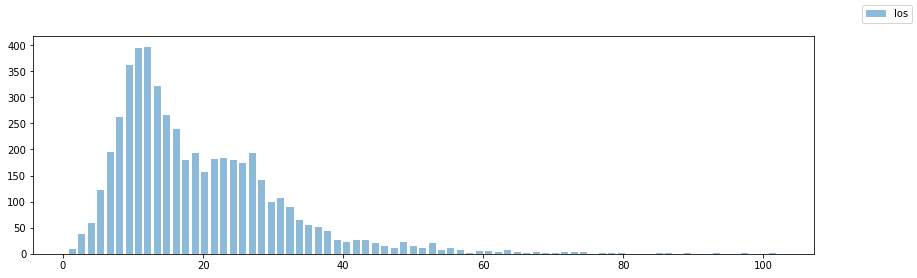

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(static["length_of_stay_in_er"], bins=75, alpha=0.5, width=1, label="los")
fig.legend(loc="upper right")
plt.show()

In [8]:
m1 = (static['length_of_stay_in_er']>=0) & (static['length_of_stay_in_er']<7)
m2 = (static['length_of_stay_in_er']>=7) & (static['length_of_stay_in_er']<14)
m3 = (static['length_of_stay_in_er']>=14) & (static['length_of_stay_in_er']<30)

vals = [1, 2, 3]
default = 4

static['los_er_derived'] = np.select([m1,m2,m3], vals, default=default)

<IPython.core.display.Javascript object>

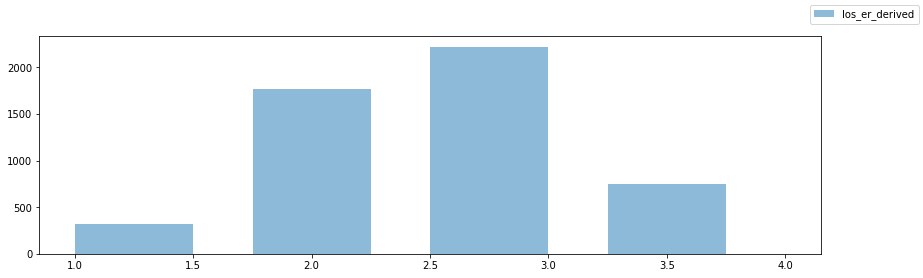

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(static["los_er_derived"], bins=4, alpha=0.5, width=0.5, label="los_er_derived")
fig.legend(loc="upper right")
plt.show()

In [10]:
ref_temporal = feature_handler.reference['temporal']
ref_temporal

Empty DataFrame
Columns: []
Index: [(11100097, 0), (11100097, 1), (11100097, 2), (11100097, 3), (11100097, 4), (11100097, 5), (11100097, 6), (11100097, 7), (11100164, 0), (11100164, 1), (11100164, 2), (11100164, 3), (11100164, 4), (11100164, 5), (11100164, 6), (11100164, 7), (11100176, 0), (11100176, 1), (11100176, 2), (11100176, 3), (11100176, 4), (11100176, 5), (11100176, 6), (11100176, 7), (11100375, 0), (11100375, 1), (11100375, 2), (11100375, 3), (11100375, 4), (11100375, 5), (11100375, 6), (11100375, 7), (11100461, 0), (11100461, 1), (11100461, 2), (11100461, 3), (11100461, 4), (11100461, 5), (11100461, 6), (11100461, 7), (11100746, 0), (11100746, 1), (11100746, 2), (11100746, 3), (11100746, 4), (11100746, 5), (11100746, 6), (11100746, 7), (11100782, 0), (11100782, 1), (11100782, 2), (11100782, 3), (11100782, 4), (11100782, 5), (11100782, 6), (11100782, 7), (11100856, 0), (11100856, 1), (11100856, 2), (11100856, 3), (11100856, 4), (11100856, 5), (11100856, 6), (11100856, 7), (11101148, 0), (11101148, 1), (11101148, 2), (11101148, 3), (11101148, 4), (11101148, 5), (11101148, 6), (11101148, 7), (11101350, 0), (11101350, 1), (11101350, 2), (11101350, 3), (11101350, 4), (11101350, 5), (11101350, 6), (11101350, 7), (11101419, 0), (11101419, 1), (11101419, 2), (11101419, 3), (11101419, 4), (11101419, 5), (11101419, 6), (11101419, 7), (11102127, 0), (11102127, 1), (11102127, 2), (11102127, 3), (11102127, 4), (11102127, 5), (11102127, 6), (11102127, 7), (11102386, 0), (11102386, 1), (11102386, 2), (11102386, 3), ...]

[36904 rows x 0 columns]

<IPython.core.display.Javascript object>

In [11]:
temporal = feature_handler.features['temporal']
samples=len(temporal.index.unique(level=0))
timesteps=len(temporal.index.unique(level=1))
features=temporal.shape[1]
print("Encounters:",samples)
print("Timesteps:",timesteps)
print("Temporal Features:",features)

Encounters: 4613
Timesteps: 8
Temporal Features: 12


<IPython.core.display.Javascript object>

In [12]:
temporal = temporal.rename_axis("features", axis="columns")
temporal

features               bicarbonate  creatinine  hematocrit  hemoglobin  \
encounter_id timestep                                                    
11100097     0                21.0        46.0       0.467       152.0   
             1                 NaN         NaN         NaN         NaN   
             2                25.0        39.0       0.446       141.0   
             3                 NaN         NaN         NaN         NaN   
             4                 NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
11917974     3                 NaN         NaN         NaN         NaN   
             4                 NaN         NaN         NaN         NaN   
             5                 NaN         NaN         NaN         NaN   
             6                 NaN         NaN         NaN         NaN   
             7                 NaN         NaN         NaN         NaN   

features               lymphocyte  mean cell volume  neutrophils  \
encounter_id timestep                                              
11100097     0               1.97              98.7        12.31   
             1                NaN               NaN          NaN   
             2               1.29             100.7         7.35   
             3                NaN               NaN          NaN   
             4                NaN               NaN          NaN   
...                           ...               ...          ...   
11917974     3                NaN               NaN          NaN   
             4                NaN               NaN          NaN   
             5                NaN               NaN          NaN   
             6                NaN               NaN          NaN   
             7                NaN               NaN          NaN   

features               platelet count  potassium  sodium  \
encounter_id timestep                                      
11100097     0                  305.0        5.5   128.0   
             1                    NaN        NaN     NaN   
             2                  244.0        4.2   133.0   
             3                    NaN        NaN     NaN   
             4                    NaN        NaN     NaN   
...                               ...        ...     ...   
11917974     3                    NaN        NaN     NaN   
             4                    NaN        NaN     NaN   
             5                    NaN        NaN     NaN   
             6                    NaN        NaN     NaN   
             7                    NaN        NaN     NaN   

features               white blood cell count  oxygen_delivery  
encounter_id timestep                                           
11100097     0                          15.74              NaN  
             1                            NaN              NaN  
             2                           9.69              NaN  
             3                            NaN              NaN  
             4                            NaN              NaN  
...                                       ...              ...  
11917974     3                            NaN              1.0  
             4                            NaN              1.0  
             5                            NaN              1.0  
             6                            NaN              1.0  
             7                            NaN              1.0  

[36904 rows x 12 columns]

<IPython.core.display.Javascript object>

In [39]:
outcome = "los_er_derived"
batch_size = 1
input_dim = features*3
output_dim = 1
hidden_dim = 128
layer_dim = 1
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

device = get_device()

X = temporal[np.in1d(temporal.index.get_level_values(0), static.index.get_level_values(0))]
y = static[np.in1d(static.index.get_level_values(0), X.index.get_level_values(0))]
y_train, y_val = train_test_split(y, test_size=1/2)
y_val, y_test = train_test_split(y_val, test_size=1/2)
X_train = X[np.in1d(X.index.get_level_values(0), y_train.index.get_level_values(0))]
X_train_inputs = format_dataset(X_train, level="features",imputation_method="simple")
X_val = X[np.in1d(X.index.get_level_values(0), y_val.index.get_level_values(0))]
X_val_inputs = format_dataset(X_val, level="features",imputation_method="simple")
X_test = X[np.in1d(X.index.get_level_values(0), y_test.index.get_level_values(0))]
X_test_inputs = format_dataset(X_test, level="features",imputation_method="simple")
y_train = y_train[[outcome]].to_numpy().reshape(len(y_train),1)
y_val = y_val[[outcome]].to_numpy().reshape(len(y_val),1)
y_test = y_test[[outcome]].to_numpy().reshape(len(y_test),1)

train_dataset = get_data(X_train_inputs,y_train)
train_loader = train_dataset.to_loader(batch_size) 

val_dataset = get_data(X_val_inputs,y_val)
val_loader = val_dataset.to_loader(batch_size)

/mnt/nfs/home/subasriv/cyclops/drift_detection/models/temporal/pytorch/temporal_model_utils.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  output=np.dstack((X.loc[(slice(None), i), :].values for i in sorted(set(timestep_in_values))))
/mnt/nfs/home/subasriv/cyclops/drift_detection/models/temporal/pytorch/temporal_model_utils.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  output=np.dstack((X.loc[(slice(None), i), :].values for i in sorted(set(timestep_in_values))))
/mnt/nfs/home/subasriv/cyclops/drift_detection/models/temporal/pytorch/temporal_model_utils.py:91: FutureWarning: arrays to stack must be passed as a "sequence" type such as list o

<IPython.core.display.Javascript object>

In [40]:
model_params = {'device': device,
                'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_temporal_model('lstmcell', model_params).to(device)

<IPython.core.display.Javascript object>

[1/10] Training loss: 0.0000	 Validation loss: 0.0000
[2/10] Training loss: 0.0000	 Validation loss: 0.0000
[3/10] Training loss: 0.0000	 Validation loss: 0.0000
[4/10] Training loss: 0.0000	 Validation loss: 0.0000
[5/10] Training loss: 0.0000	 Validation loss: 0.0000
[6/10] Training loss: 0.0000	 Validation loss: 0.0000
[7/10] Training loss: 0.0000	 Validation loss: 0.0000
[8/10] Training loss: 0.0000	 Validation loss: 0.0000
[9/10] Training loss: 0.0000	 Validation loss: 0.0000
[10/10] Training loss: 0.0000	 Validation loss: 0.0000


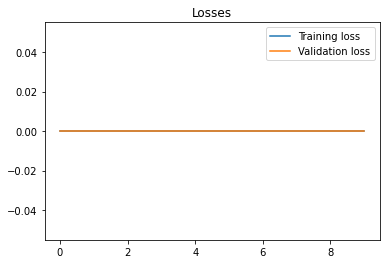

<IPython.core.display.Javascript object>

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
activation = nn.Softmax(dim=1)
opt = Optimizer(model=model, loss_fn=loss_fn, optimizer=optimizer,activation=activation)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [42]:
test_dataset = get_data(X_test_inputs,y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
predictions, values, tags = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

Accuracy: 0.0 %


<IPython.core.display.Javascript object>

In [73]:
df_result = format_predictions(predictions, values, tags, X_test)

<IPython.core.display.Javascript object>

In [75]:
df_result.head(n=20)

value  prediction  tag
encounter_id timestep                        
11100461     0           0.0    0.154417  1.0
             1           0.0    0.123046  1.0
             2           0.0   17.191126  1.0
             3           0.0   17.194895  1.0
             4           0.0   17.191628  1.0
             5           0.0   17.192944  1.0
             6           0.0   17.193739  1.0
             7           1.0   17.194275  1.0
11101148     0           0.0   17.189415  1.0
             1           1.0   17.188330  1.0
             2           0.0   17.193487  1.0
             3           0.0   17.194447  1.0
             4           0.0   17.194704  1.0
             5           0.0   17.193975  1.0
             6           0.0   17.193010  1.0
             7           0.0   17.195467  1.0
11101350     0           0.0   17.195084  1.0
             1           0.0   17.193903  1.0
             2           0.0   17.195047  1.0
             3           0.0   17.194380  1.0

<IPython.core.display.Javascript object>